In [33]:
import sys
import os
import pandas as pd
from datetime import datetime
from helper_functions import fetch_granular_data,fetch_and_save_csv_files, csv_to_df
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load aggregate data from CSVs
def load_csvs_from_data_folder(data_folder, date_str):
    # Create the path to the data folder for the given date
    date_folder_path = os.path.join(data_folder, date_str)
    # print(date_folder_path)
    
    # Check if the folder exists
    if not os.path.exists(date_folder_path) :
        fetch_and_save_csv_files()
    elif len(os.listdir(date_folder_path)) < 4  :
        fetch_and_save_csv_files()
        
    # Dictionary to hold dataframes
    dataframes = {}
    dataframes = csv_to_df(date_folder_path)
    return dataframes
    
#Todays date
today_str = datetime.now().strftime('%Y-%m-%d')
data_folder = '..\\data'

# Load dataframes from CSVs
dfs = load_csvs_from_data_folder(data_folder, today_str)


In [34]:
def perform_eda(df, name):
    print(f"EDA for {name}:")
    
    # print("\nFirst few rows:")
    # print(df.iloc[:,:5].head())
    
    print("\nInfo:")
    df.info()
    
    # Display basic statistics
    # print("\nDescribe:")
    # print(df.describe())
    
    # Check for null values
    # print("\nNull values:")
    # print(df.isnull().sum())
    
    # Check for duplicate rows
    # print("\nNumber of duplicate rows:")
    # print(df.duplicated().sum())

# Perform EDA on each dataframe
for name, df in dfs.items():
    perform_eda(df, name)
    print("\n" + "="*50 + "\n")

EDA for donations_facility:

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145156 entries, 0 to 145155
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     145156 non-null  datetime64[ns]
 1   hospital                 145156 non-null  object        
 2   daily                    145156 non-null  int64         
 3   blood_a                  145156 non-null  int64         
 4   blood_b                  145156 non-null  int64         
 5   blood_o                  145156 non-null  int64         
 6   blood_ab                 145156 non-null  int64         
 7   location_centre          145156 non-null  int64         
 8   location_mobile          145156 non-null  int64         
 9   type_wholeblood          145156 non-null  int64         
 10  type_apheresis_platelet  145156 non-null  int64         
 11  type_apheresis_plasma    145156 non-null  i

In [35]:
#Observing the values in the state columns
dfs['donations_state']['state'].value_counts()

#Malaysia is not a state

state
Malaysia             6598
Johor                6598
Kedah                6598
Kelantan             6598
Melaka               6598
Negeri Sembilan      6598
Pahang               6598
Perak                6598
Pulau Pinang         6598
Sabah                6598
Sarawak              6598
Selangor             6598
Terengganu           6598
W.P. Kuala Lumpur    6598
Name: count, dtype: int64

In [36]:
# Define the main outputs and the corresponding columns in dataframes
variable_outputs = {
    'blood_type': ['blood_a', 'blood_b', 'blood_o', 'blood_ab'],
    'location': ['location_centre', 'location_mobile'],
    'donation_type': ['type_wholeblood', 'type_apheresis_platelet', 'type_apheresis_plasma', 'type_other'],
    'social_class': ['social_civilian', 'social_student', 'social_policearmy'],
    'donation_regularity': ['donations_new', 'donations_regular', 'donations_irregular'],
}

#Lets answer the question on why is there a malaysia state
donations_state = dfs['donations_state']
#Set the dates into datetime
donations_state.loc[:,'date'] = pd.to_datetime(donations_state['date'])
donations_state.set_index('date',inplace=True)

#Separate Malaysia and other states
malaysia_total = donations_state[donations_state['state'] == 'Malaysia']['daily'].sum()
state_total = donations_state[donations_state['state'] != 'Malaysia']['daily'].sum()
print(malaysia_total, state_total)

8288659 8288659


Okay evidently its just an aggregate of all the states on any given date. Therefore lets separate it as a different df.


In [37]:
# Separate the data into two DataFrames: one for Malaysia and one for the states
ms_df = donations_state.loc[donations_state['state'] == 'Malaysia', :]
state_df = donations_state.loc[donations_state['state'] != 'Malaysia', :]

In [38]:
# Check the first few rows to ensure the DataFrame looks as expected
print(state_df.loc[ :,['state','daily'] ].head())
print(ms_df.loc[:,'daily'].head())

            state  daily
date                    
2006-01-01  Johor     87
2006-01-02  Johor     15
2006-01-03  Johor      8
2006-01-04  Johor     33
2006-01-05  Johor     20
date
2006-01-01    525
2006-01-02    227
2006-01-03    112
2006-01-04    391
2006-01-05    582
Name: daily, dtype: int64


Lets analyse the states first.


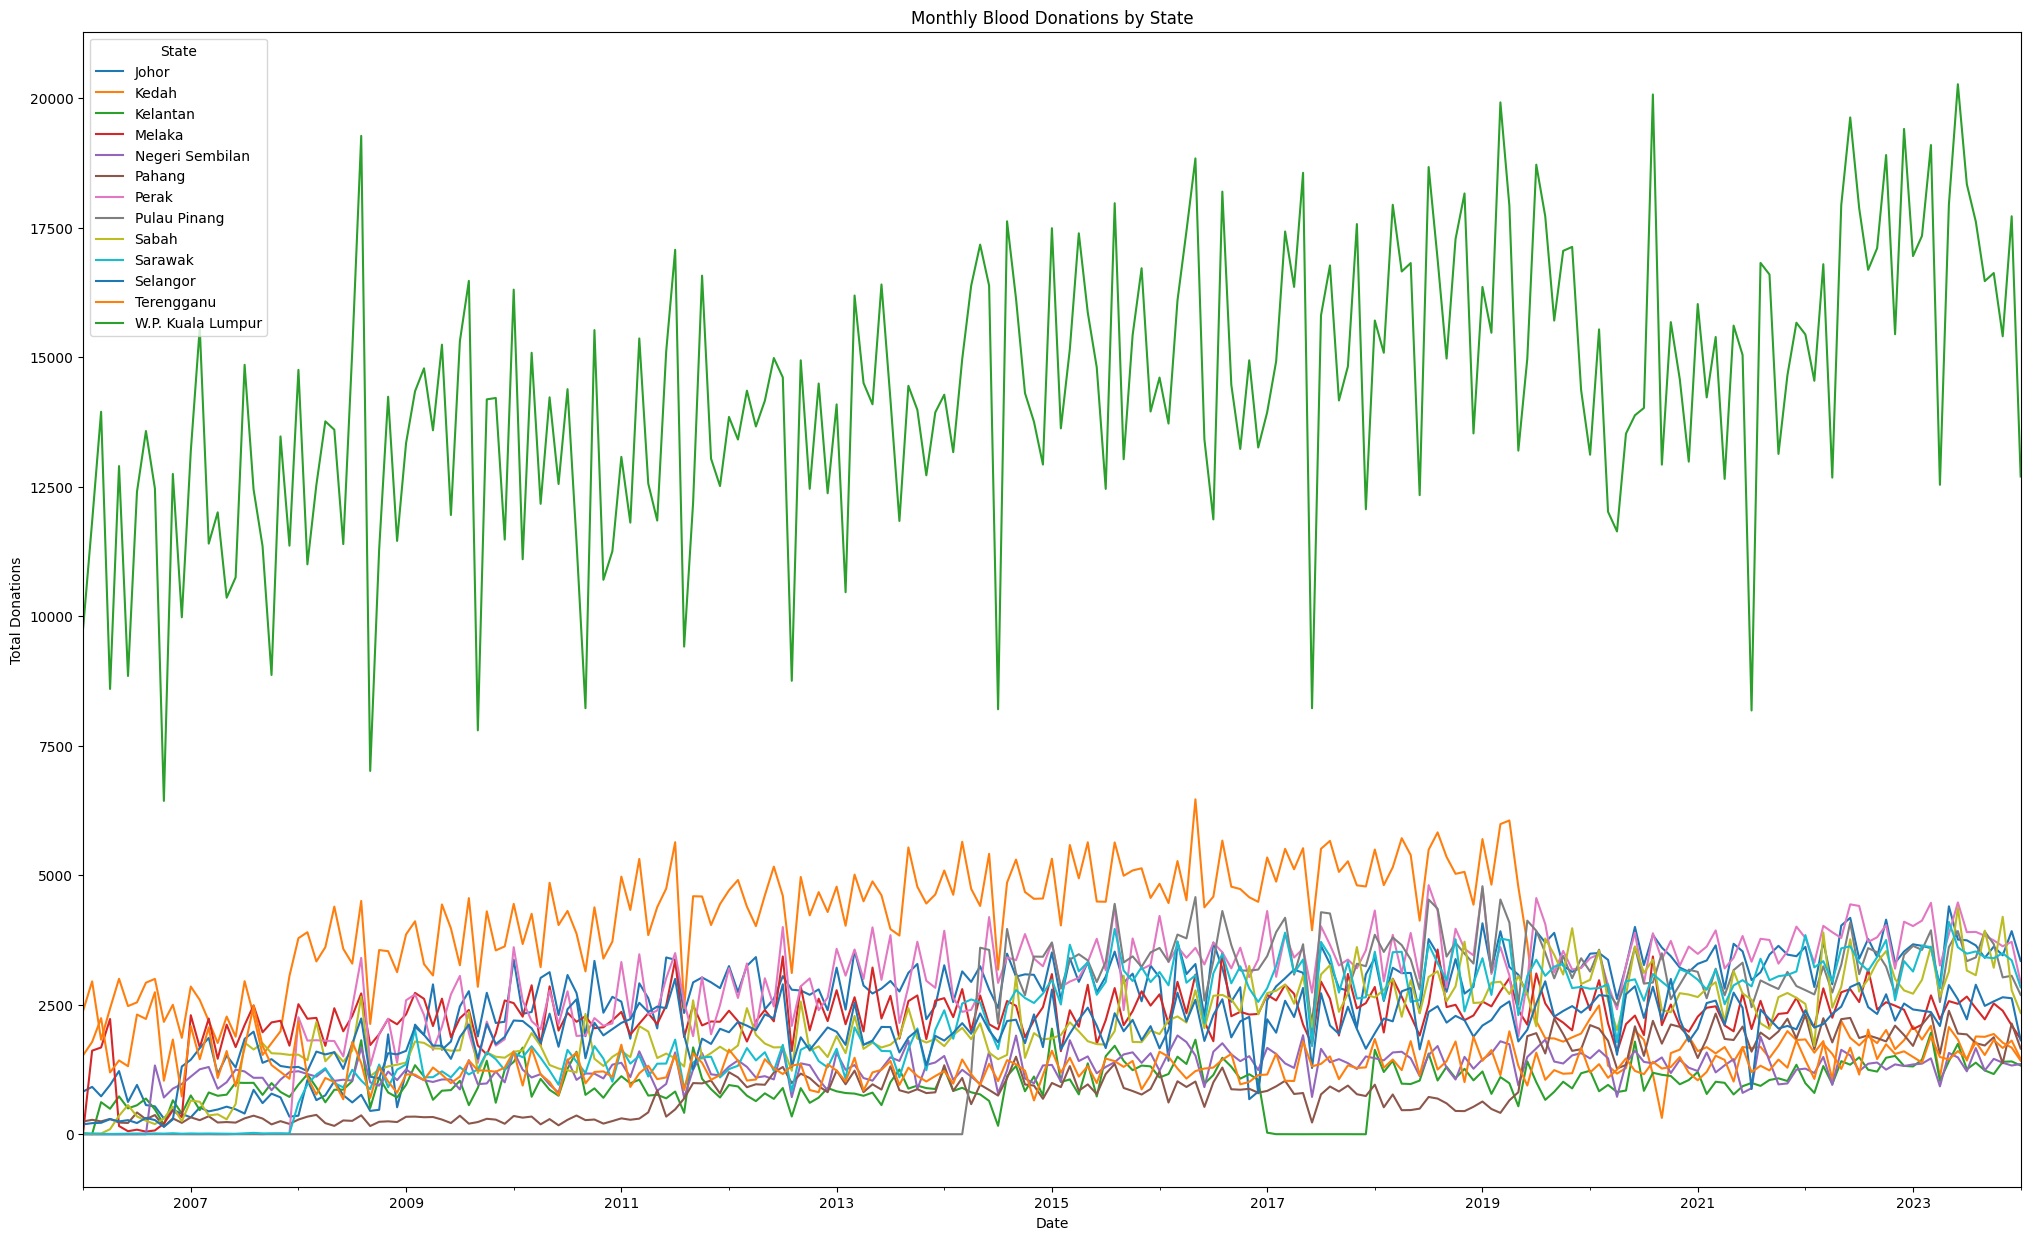

In [39]:
# Group the data by state and resample to a monthly frequency, summing the daily donations
monthly_donations_by_state = state_df.groupby('state').resample('M').sum().loc[:, 'daily']

# Plotting the trends
plt.figure(figsize=(25, 15))
for state in monthly_donations_by_state.index.get_level_values(0).unique():
    monthly_donations_by_state.xs(state, level='state').plot(label=state)
plt.title('Monthly Blood Donations by State')
plt.xlabel('Date')
plt.ylabel('Total Donations')
plt.legend(title='State')
plt.show()


**First impressions**

- KL is by far the leader in volume of blood donations, hovering around 12,500-15,000 blood donations monthly.
- All the other states all are only below 5,000 monthly donations a month.


**A few things to note**

- Negeri Sembilan only started donating blood in 2014. 
- Kelantan stopped donating in 2017-2018.
- Sharp decline in Kedah after 2019 (Presumably from Covid)(Kedah does include Penang)

In [40]:
#Lets look into the other states now

from statsmodels.tsa.seasonal import seasonal_decompose as sm

monthly_donations_by_state = state_df.groupby(['state', pd.Grouper(freq='M')])['daily'].sum()

# Pivot the table to have states as columns and dates as rows
monthly_donations_by_state = monthly_donations_by_state.unstack(level=0)


In [41]:
def decompose_and_plot(state, df, mean_donations = None, model='additive'):
    # Check if the state's data exists in the DataFrame
    if state not in df.columns:
        print(f"No data for state: {state}")
        return
    
    if mean_donations is not None:
        rank = mean_donations.rank(ascending=False)[state]
    
    # Perform seasonal decomposition
    series = df[state].dropna()  # Drop NA values for decomposition
    decomposition = sm(series, model=model, period=12)  # Monthly data usually has a period of 12
    
    # Plot the decomposed components
    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 8))
    decomposition.observed.plot(ax=axes[0], legend=False, title='Observed')
    decomposition.trend.plot(ax=axes[1], legend=False, title='Trend')
    decomposition.seasonal.plot(ax=axes[2], legend=False, title='Seasonal')
    decomposition.resid.plot(ax=axes[3], legend=False, title='Residual')
   
    if mean_donations is not None : 
        plt.suptitle(f'Seasonal Decompose of {state} Blood Donations (Rank {int(rank)})')
    else:
        plt.suptitle(f'Seasonal Decompose of {state} Blood Donations')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
    plt.show()

# print(high_states)
# print(low_states)
# Decompose and plot for the selected states
# for state in high_states.union(low_states):
#     decompose_and_plot(state, monthly_donations_by_state, 'multiplicative')

#Doesnt work with multiplicative!


In [42]:
def df_cleans_before_decompose(df):
    #Forward-fill, replace NA and ensure no negative values in the dataset
    df.ffill()
    df.fillna(0,inplace=True)
    df[df < 0] = 0
    return df

In [43]:
# Calculate mean donations per state to determine highest and lowest
mean_donations = monthly_donations_by_state.mean().sort_values()

# Take two states with the highest and two with the lowest mean donations
if mean_donations is not None:
    high_states = mean_donations.index[-2:]
    low_states = mean_donations.index[:2]

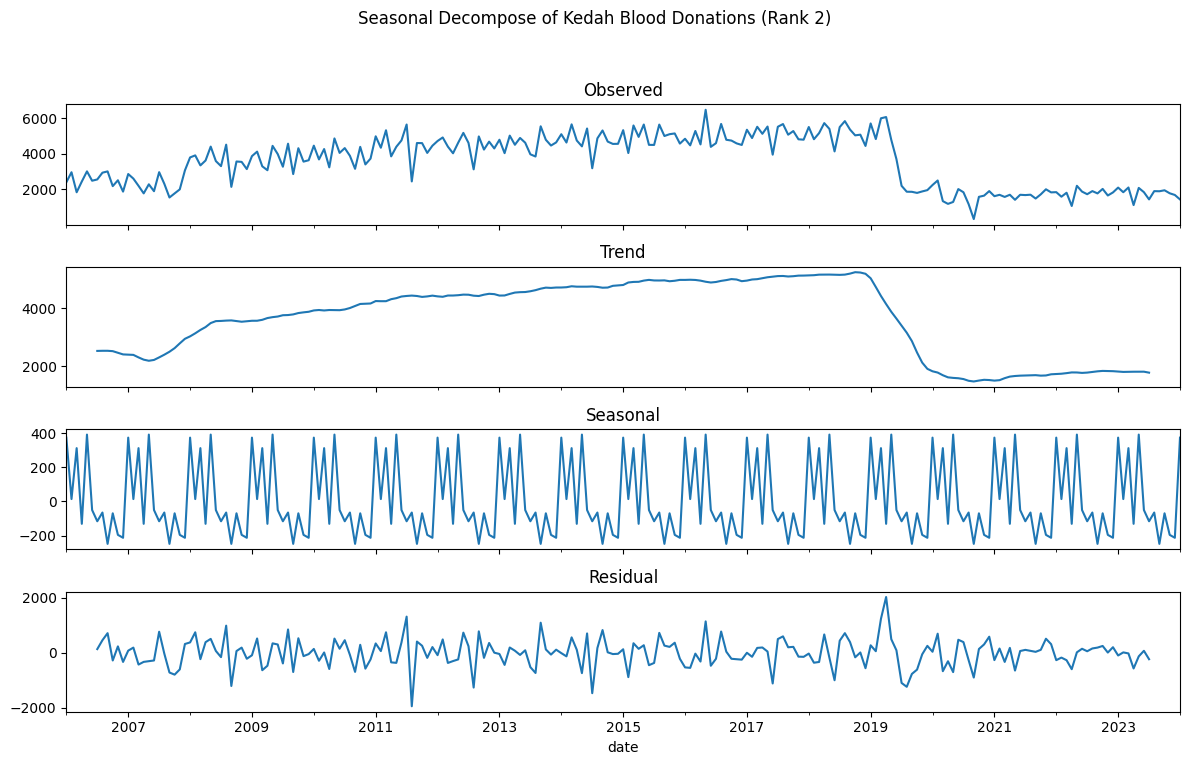

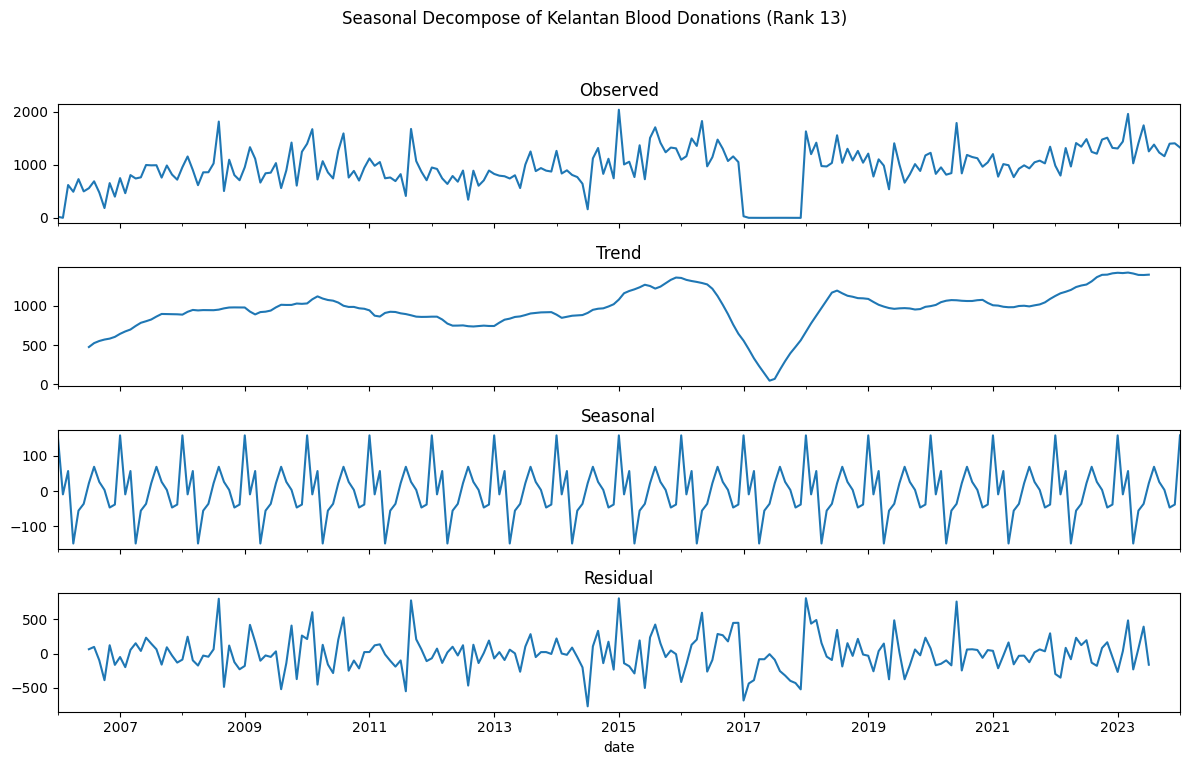

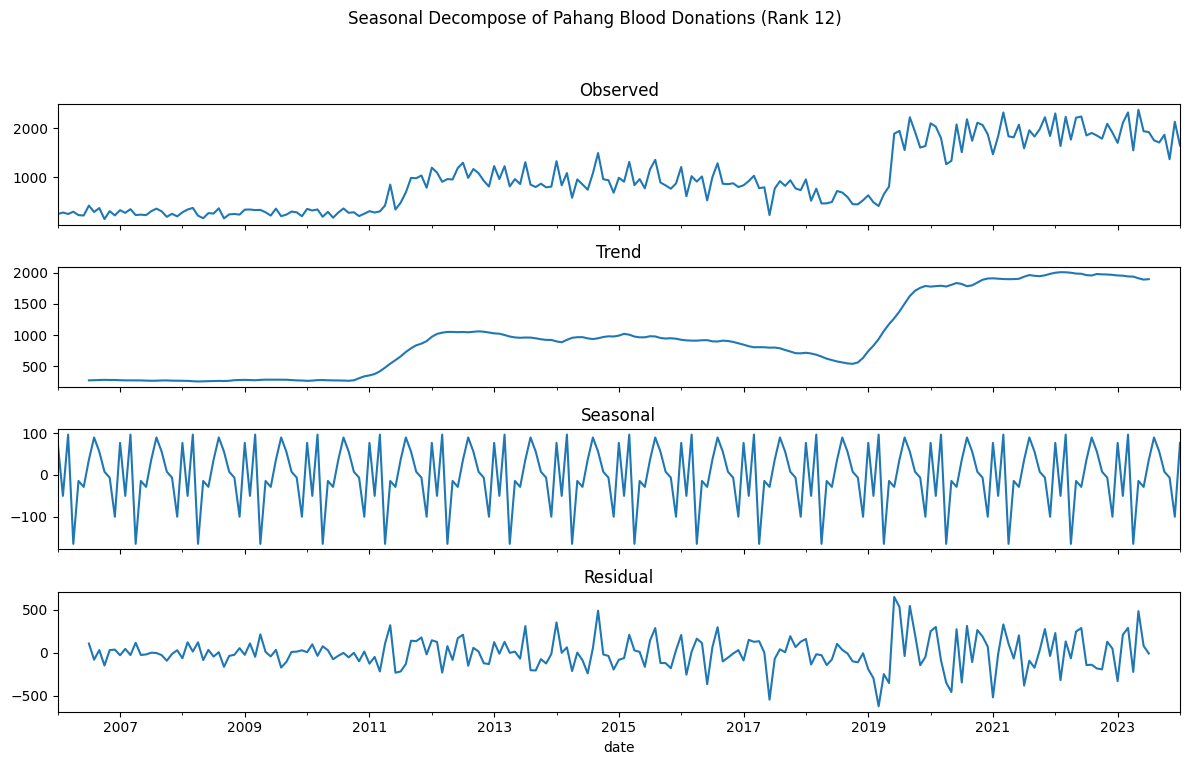

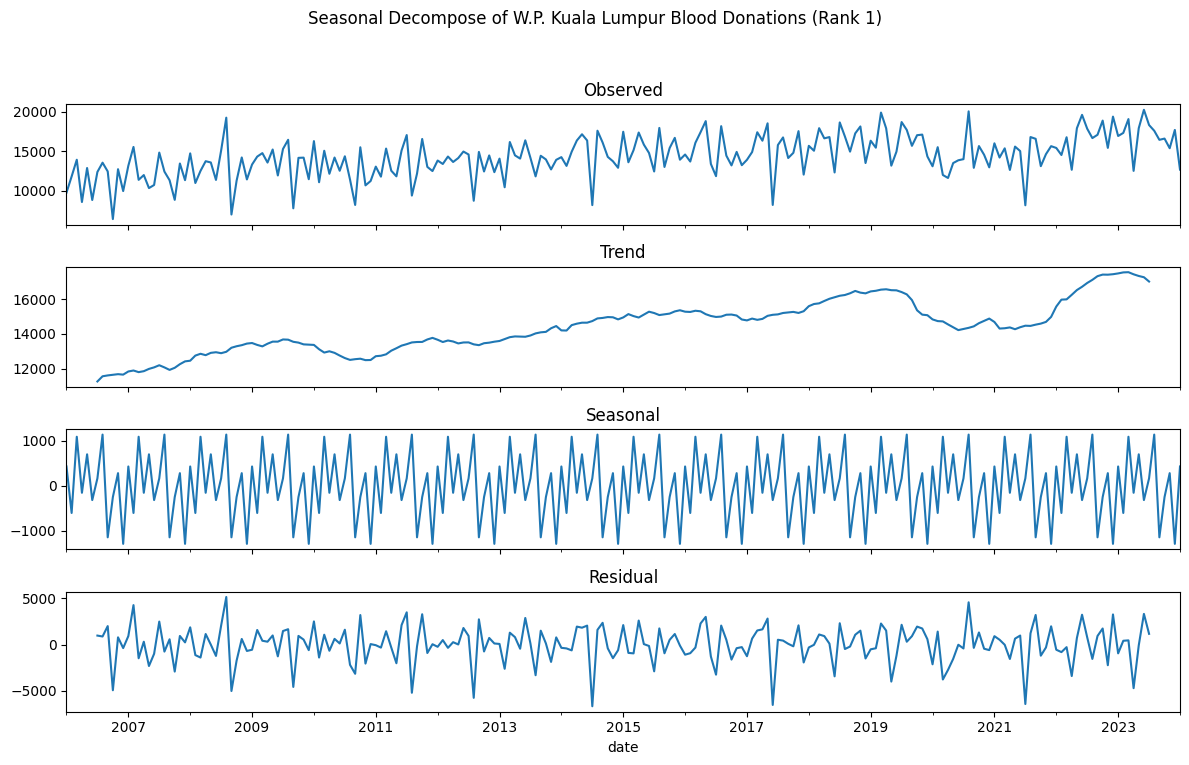

In [44]:
monthly_donations_by_state_ffill = df_cleans_before_decompose(monthly_donations_by_state)
# Now, can safely proceed with an additive model
for state in high_states.union(low_states):
    decompose_and_plot(state, monthly_donations_by_state_ffill, mean_donations,model= 'additive')

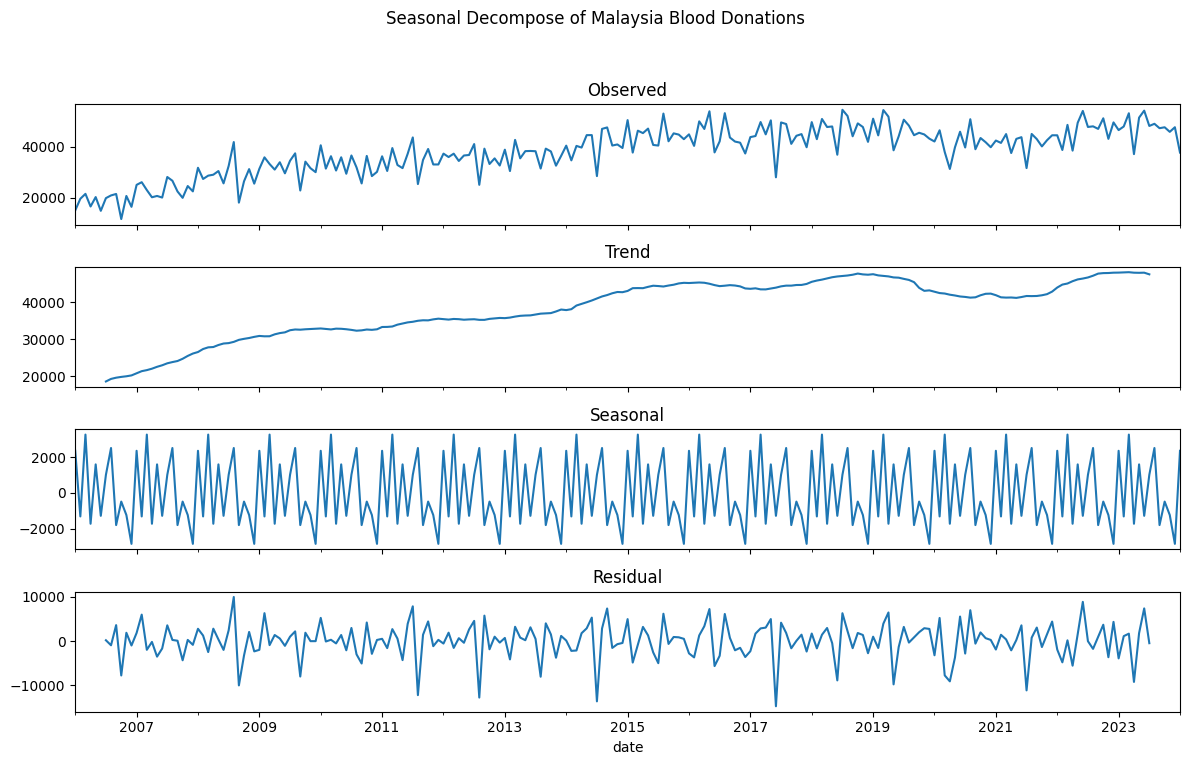

In [45]:
# Seasonal decompose of Malaysia
monthly_donations_malaysia = ms_df.groupby(['state', pd.Grouper(freq='M')])['daily'].sum().unstack(level=0)

decompose_and_plot('Malaysia',monthly_donations_malaysia,model='additive' )

In [46]:
from statsmodels.tsa.stattools import adfuller, kpss

adf_result_malaysia = adfuller(monthly_donations_malaysia)
kpss_result_malaysia = kpss(monthly_donations_malaysia,regression = 'c')

print(adf_result_malaysia,"\n###########################\n",kpss_result_malaysia)

(-2.284372285049418, 0.17705776722016303, 14, 202, {'1%': -3.4631437906252636, '5%': -2.8759570379821047, '10%': -2.574454682874228}, 3925.5289872195904) 
###########################
 (1.891591976918079, 0.01, 9, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\azaid\AppData\Local\Temp\ipykernel_16252\1421297333.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result_malaysia = kpss(monthly_donations_malaysia,regression = 'c')



## Statistical Tests

### The Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test results provide with information about the stationarity of the blood donation time series data for Malaysia:

### ADF Test Result:

Test Statistic: -2.3188
p-value: 0.1659
Number of Lags Used: 14
Number of Observations Used: 202
Critical Values: {'1%': -3.4631, '5%': -2.8759, '10%': -2.5745}
KPSS Test Result:

Test Statistic: 1.8849
p-value: 0.01
Number of Lags Used: 9
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

## Summary: 

The ADF test has a p-value greater than 0.05, which suggests that we cannot reject the null hypothesis of the presence of a unit root. This means the series is not stationary and may have a time-dependent structure.

The KPSS test, on the other hand, has a test statistic higher than the critical values, and a p-value of 0.01, which suggests that we can reject the null hypothesis of stationarity. This indicates that the series is non-stationary and has a trend.

Given these results, the trend in the blood donation data for Malaysia is statistically significant, implying that the donations data exhibits a systematic trend over time. However, the non-stationarity of the series also suggests that any model we use to predict future values should account for this trend component.

In [48]:
# Since the Malaysia level data showed a non-stationary trend, let's perform the ADF and KPSS tests for each state.
# We will compile the results in a DataFrame for easier comparison.

# Initialize a DataFrame to store the test results
trend_tests_results_list = []

# Threshold
adf_threshold = 0.05
kpss_threshold = 0.05

# Loop through each state and perform the tests
for state in state_df['state'].unique():
    
    # Prepare the time series data for the current state
    state_series = state_df[state_df['state'] == state].resample('M').sum()['daily']
    
    # Perform ADF test
    adf_stat, adf_p, _, _, _, _ = adfuller(state_series.dropna(), autolag='AIC')
    
    # Perform KPSS test
    kpss_stat, kpss_p, _, _ = kpss(state_series.dropna(), regression='c')

    # Determine stationarity based on p-value thresholds
    is_stationary_adf = 'Yes' if adf_p < adf_threshold else 'No'
    is_stationary_kpss = 'Yes' if kpss_p > kpss_threshold else 'No'

    # Append the results
    result_df = pd.DataFrame({
        'State': [state],
        'ADF Statistic': [adf_stat],
        'ADF p-value': [adf_p],
        'Is Stationary (ADF)': [is_stationary_adf],
        'KPSS Statistic': [kpss_stat],
        'KPSS p-value': [kpss_p],
        'Is Stationary (KPSS)': [is_stationary_kpss]
    })
    trend_tests_results_list.append(result_df)

trend_tests_results = pd.concat(trend_tests_results_list,ignore_index=True)
trend_tests_results


C:\Users\azaid\AppData\Local\Temp\ipykernel_16252\719439016.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(state_series.dropna(), regression='c')
C:\Users\azaid\AppData\Local\Temp\ipykernel_16252\719439016.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(state_series.dropna(), regression='c')
C:\Users\azaid\AppData\Local\Temp\ipykernel_16252\719439016.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(state_series.dropna(), regression='c')
C:\Users\azaid\AppData\Local\Temp\ipykernel_16252\719439016.py:21: InterpolationWa

,State,ADF Statistic,ADF p-value,Is Stationary (ADF),KPSS Statistic,KPSS p-value,Is Stationary (KPSS)
0,Johor,-2.513158,1.123057e-01,No,1.628751,0.010000,No
1,Kedah,-1.283767,6.365656e-01,No,0.594732,0.023115,No
2,Kelantan,-3.652476,4.833517e-03,Yes,0.486514,0.044704,No
3,Melaka,-5.872552,3.214821e-07,Yes,0.942063,0.010000,No
4,Negeri Sembilan,-2.783050,6.073601e-02,No,1.264092,0.010000,No
5,Pahang,-1.113926,7.094865e-01,No,1.732809,0.010000,No
6,Perak,-3.254017,1.706330e-02,Yes,1.687458,0.010000,No
7,Pulau Pinang,-1.320801,6.196031e-01,No,1.811577,0.010000,No
8,Sabah,-2.009128,2.825851e-01,No,2.000251,0.010000,No
9,Sarawak,-2.071659,2.560621e-01,No,2.014383,0.010000,No


In [ ]:
# To analyze the differenced series and confirm stationarity, we will first difference the data and then re-run the ADF test.

# Let's create a function to perform differencing and conduct the ADF test
def test_stationarity_of_differenced_series(series, adf_threshold=0.05):
    # Perform differencing to remove trends
    differenced_series = series.diff().dropna()
    
    # Conduct ADF test on the differenced series
    adf_result = adfuller(differenced_series, autolag='AIC')
    
    # Determine if the series is stationary based on the ADF test p-value
    is_stationary = adf_result[1] < adf_threshold
    
    # Return the differenced series and the ADF test result
    return differenced_series, adf_result, is_stationary

# Initialize a DataFrame to store the differencing results
differencing_results_list = []

# Loop through each state and test the stationarity of the differenced series
for state in state_df['state'].unique():
    
    # Extract the time series data for the current state
    state_series = state_df[state_df['state'] == state].resample('M').sum()['daily']
    
    # Test the stationarity of the differenced series
    _, adf_result, is_stationary = test_stationarity_of_differenced_series(state_series)
    
    # Append the results to the DataFrame
    result_df = pd.DataFrame({
        'State': [state],
        'ADF Statistic': [adf_result[0]],
        'ADF p-value': [adf_result[1]],
        'Is Stationary': [is_stationary]
    })
    differencing_results_list.append(result_df)

differencing_results = pd.concat(differencing_results_list,ignore_index=True)
differencing_results


,State,ADF Statistic,ADF p-value,Is Stationary
0,Johor,-4.131377,8.591103e-04,True
1,Kedah,-3.935552,1.788240e-03,True
2,Kelantan,-12.880958,4.660062e-24,True
3,Melaka,-5.143313,1.146388e-05,True
4,Negeri Sembilan,-7.640009,1.906996e-11,True
5,Pahang,-10.711017,3.331840e-19,True
6,Perak,-4.974588,2.491196e-05,True
7,Pulau Pinang,-3.709625,3.979783e-03,True
8,Sabah,-4.357380,3.528543e-04,True
9,Sarawak,-3.410324,1.061191e-02,True
